In [1]:
# https://medium.com/datadriveninvestor/linear-regression-using-tensorflow-estimator-9aa570914375

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing

%matplotlib inline

In [3]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../data")
df = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysis.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysistest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,7.452470,0.000129,0.000000,1.484572e+04,0.006211,7.686411e+02,690.618472,1.0,7.0,0.427801,12.0,76.330988,5.045532e+10,10.168922
1,6.314931,0.056578,903.680000,7.635895e+06,0.006211,4.423151e+06,44196.825694,1.0,42.0,0.441701,12.0,76.330988,5.045532e+10,10.168922
2,9.499113,0.073244,1001.244444,9.543407e+06,0.006211,4.011359e+06,41064.000000,1.0,76.0,0.429230,12.0,13.216667,5.045532e+10,10.329697
3,6.085528,0.073156,1001.244444,9.533212e+06,0.026095,4.012145e+06,42053.311111,1.0,112.0,0.421655,12.0,13.216667,5.045532e+10,10.329697
4,9.452724,0.021956,182.044444,2.628813e+06,0.119376,3.909378e+03,3469.288889,1.0,140.0,0.439443,12.0,14.213889,5.045532e+10,10.159327


In [4]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [5]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [6]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*df['totalcpu'])/100
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*df_test['totalcpu'])/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests,replica
0,9.159719,513.076211,0.427801,7.0,1.0
1,9.159719,513.076211,0.441701,42.0,1.0
2,1.586000,521.188136,0.429230,76.0,1.0
3,1.586000,521.188136,0.421655,112.0,1.0
4,1.705667,512.592066,0.439443,140.0,1.0


In [7]:
#muthu = df_t
#X = muthu.loc[:,['total_cpu_util','total_mem_util','replica', 'requests']].values
#X = preprocessing.normalize(X, norm='max')
#y = muthu.loc[:,['responsetime']].values
#kf = KFold(n_splits=7, random_state=42, shuffle=True)
#for train_index, test_index in kf.split(X):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    print(X_train, '\n', y_train)
#    print(X_test, '\n', y_test)

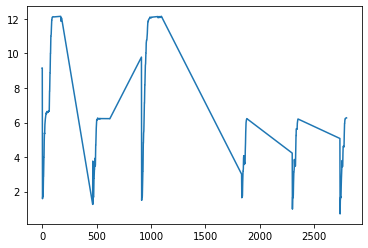

In [8]:
plt.plot(df_t['total_cpu_util'])

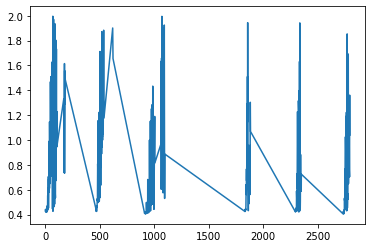

In [9]:
plt.plot(df_t['responsetime'])

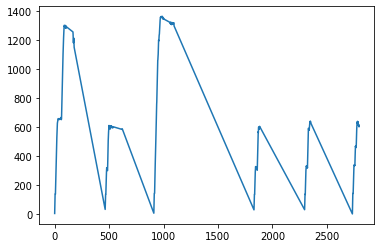

In [10]:
plt.plot(df_t['requests'])

In [11]:
n = len(df_t)
train_df = df_t[0:int(n*0.8)]
eval_df = df_t[int(n*0.8):]
test_df = df_ttest[:]

#train_mean = train_df.mean()
#print(train_mean)
#train_std = train_df.std()
#print(train_std)

#train_df = (train_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std
#train_df

In [12]:
#import seaborn as sns
#df_std = (df_t - train_mean) / train_std
##print(df_std)
#df_std = df_std.melt(var_name='Column', value_name='Normalized')
##print(df_std)
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(df_t.keys(), rotation=90)

In [13]:
x_train = train_df[[col for col in train_df.columns if col != 'requests']]
y_train = train_df['requests']
x_val = eval_df[[col for col in eval_df.columns if col != 'requests']]
y_val = eval_df['requests']
x_test = test_df[[col for col in eval_df.columns if col != 'requests']]
y_test = test_df['requests']

In [14]:
#x_data.describe(include='all')

In [15]:
#x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.3)

In [16]:
feature_col = [tf.feature_column.numeric_column(col) for col in x_train.columns]

In [17]:
opti = tf.optimizers.Adam(learning_rate = 0.01)

In [18]:
input_func= tf.compat.v1.estimator.inputs.pandas_input_fn(x=x_train, 
                                                y= y_train, 
                                                batch_size=100, 
                                                num_epochs=1000, 
                                                shuffle=False)

In [19]:
test_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x= x_test,                                                   
                                                 batch_size=10, 
                                                 num_epochs=1, 
                                                 shuffle=False)
eval_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=x_val,
                                                      y=y_val, 
                                                      batch_size=10, 
                                                      num_epochs=1, 
                                                      shuffle=False)

In [20]:
estimator = tf.estimator.DNNRegressor(hidden_units=[4,4,1], feature_columns=feature_col, optimizer=opti)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprejrmy7h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
estimator.train(input_fn=input_func,steps=10000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op

In [22]:
result_eval = estimator.evaluate(input_fn=eval_input_func)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-13T09:06:41Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprejrmy7h/model.ckpt-3800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.26804s
INFO:tensorflow:Finished evaluation at 2020-10-13-09:06:41
INFO:tensorflow:Saving dict for global step 3800: average_loss = 202548.11, glo

In [23]:
result_eval

{'average_loss': 202548.11,
 'label/mean': 453.73685,
 'loss': 209036.02,
 'prediction/mean': 35.9624,
 'global_step': 3800}

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprejrmy7h/model.ckpt-3800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'predicted values')

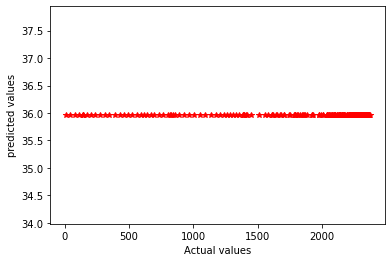

In [24]:
predictions=[]
for pred in estimator.predict(input_fn=test_input_func):
    predictions.append(np.array(pred['predictions']).astype(float))
plt.plot(y_test, predictions, 'r*')
plt.xlabel('Actual values')
plt.ylabel('predicted values')

In [25]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, predictions))**0.5

43.67485534623049

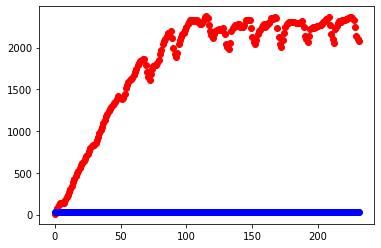

In [26]:
plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(predictions)),predictions, color='blue')

In [27]:
from sklearn.metrics import r2_score
R = r2_score(y_test, predictions)
print ('R² :',R)

R² : -7.550084725038651


In [28]:
print(y_test,predictions )

0         8.0
1        43.0
2        78.0
3       114.0
4       141.0
        ...  
228    2331.0
229    2244.0
230    2135.0
231    2106.0
232    2082.0
Name: requests, Length: 232, dtype: float64 [array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35.96239853]), array([35

# Kfold - data split